In [1]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from urllib.request import urlopen
from PIL import Image
import timm
from torch import Tensor
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from glob import glob
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random
import torchmetrics
from torch.nn.modules.batchnorm import _BatchNorm
import matplotlib.pyplot as plt
import torch.nn.functional as F
device='cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class_list={
    'background':0,
    'Tumor':1,
    'Stroma':2,
    'Immune cells':3,
    'Necrosis':4,
    'alveoli':5,
    'Other':6
}
params={'image_size':128,
        'lr':2e-4,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':32,
        'epochs':200,
        'n_classes':len(class_list),
        'inch':3,
        }

In [3]:
trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

def transback(data:Tensor) -> Tensor:
    return data / 2 + 0.5

class CustomDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self,parmas, images,label):
        
        self.images = images
        self.args=parmas
        self.label=label
        
    def trans(self,image):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            image = transform(image)
            
        return image
    
    def __getitem__(self, index):
        image=self.images[index]
        label=self.label[index]
        image = self.trans(image)
        return image,label
    
    def __len__(self):
        return len(self.images)


test_image_label=[]
test_image_path=[]


for i in tqdm(range(len(class_list))):
    image_list=glob(f'../../data/MIHIC/test/{list(class_list.keys())[i]}/*.png')
    test_image_path.extend(image_list)
    for k in range(len(image_list)):
        test_image_label.append(i)

test_images=torch.zeros((len(test_image_path),params['inch'],params['image_size'],params['image_size']))
for i in tqdm(range(len(test_image_path))):
    test_images[i]=trans(Image.open(test_image_path[i]).convert('RGB'))

test_dataset=CustomDataset(params,test_images,F.one_hot(torch.tensor(test_image_label)).to(torch.int64))
test_dataloader=DataLoader(test_dataset,batch_size=params['batch_size'],shuffle=True)


100%|██████████| 65437/65437 [01:08<00:00, 953.10it/s] 


In [4]:
class FeatureExtractor(nn.Module):
    """Feature extoractor block"""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        cnn1= timm.create_model('tf_efficientnetv2_s', pretrained=True)
        self.feature_ex = nn.Sequential(*list(cnn1.children())[:-1])

    def forward(self, inputs):
        features = self.feature_ex(inputs)
        
        return features
class custom_model(nn.Module):
    def __init__(self, num_classes, image_feature_dim,feature_extractor_scale1: FeatureExtractor):
        super(custom_model, self).__init__()
        self.num_classes = num_classes
        self.image_feature_dim = image_feature_dim

        # Remove the classification head of the CNN model
        self.feature_extractor = feature_extractor_scale1
        # Classification layer
        self.classification_layer = nn.Linear(image_feature_dim, num_classes)
        
    def forward(self, inputs):
        batch_size, channels, height, width = inputs.size()
        
        # Feature extraction using the pre-trained CNN
        features = self.feature_extractor(inputs)  # Shape: (batch_size, 2048, 1, 1)
        
        # Classification layer
        logits = self.classification_layer(features)  # Shape: (batch_size, num_classes)
        
        return logits
    
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups
        
def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, _BatchNorm):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, _BatchNorm) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum
            
import transformers

Feature_Extractor=FeatureExtractor()
model = custom_model(len(class_list),1280,Feature_Extractor)
model = model.to(device)
base_optimizer = torch.optim.SGD
# optimizer = SAM(model.parameters(), base_optimizer, lr=params['lr'], momentum=0.9)
optimizer=torch.optim.AdamW(model.parameters(), lr=params['lr'], betas=(params['beta1'], params['beta2']))
model.load_state_dict(torch.load('../../model/IHC_Tissue_Region_classification/check.pt'))
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=len(class_list)).to(device)

Evaluating: 100%|██████████| 2045/2045 [00:39<00:00, 51.23it/s]


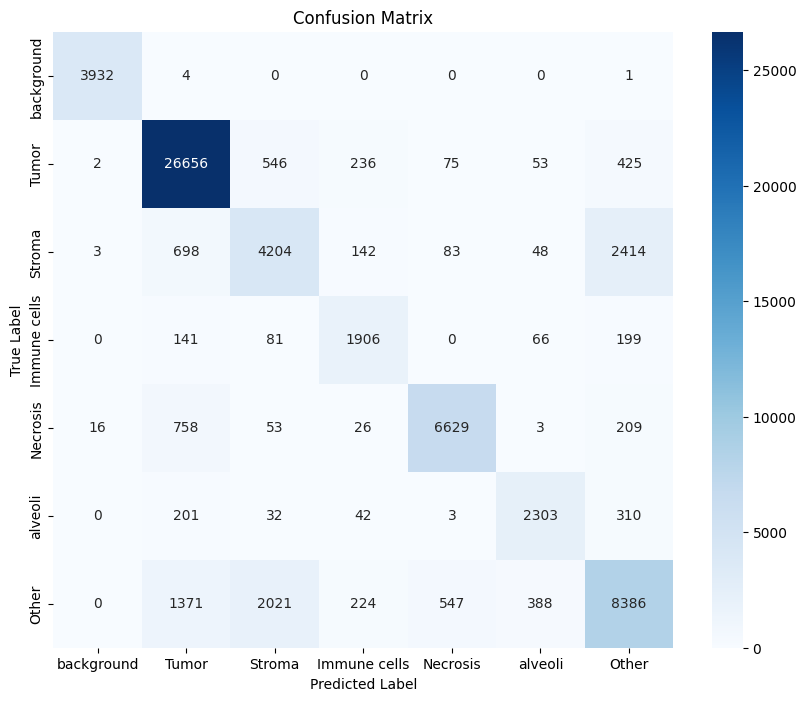

,precision,recall,f1-score,support
background,0.994688,0.998730,0.996705,3937.000000
Tumor,0.893627,0.952238,0.922002,27993.000000
Stroma,0.606026,0.553741,0.578705,7592.000000
Immune cells,0.739907,0.796490,0.767156,2393.000000
Necrosis,0.903503,0.861580,0.882044,7694.000000
alveoli,0.804963,0.796610,0.800765,2891.000000
Other,0.702110,0.648218,0.674089,12937.000000
accuracy,0.825466,0.825466,0.825466,0.825466
macro avg,0.806403,0.801087,0.803066,65437.000000
weighted avg,0.820099,0.825466,0.821937,65437.000000


전체 정확도(Accuracy): 0.8254657151153018
Macro 평균 F1: 0.8030664449032371
Weighted 평균 F1: 0.8219371425657844


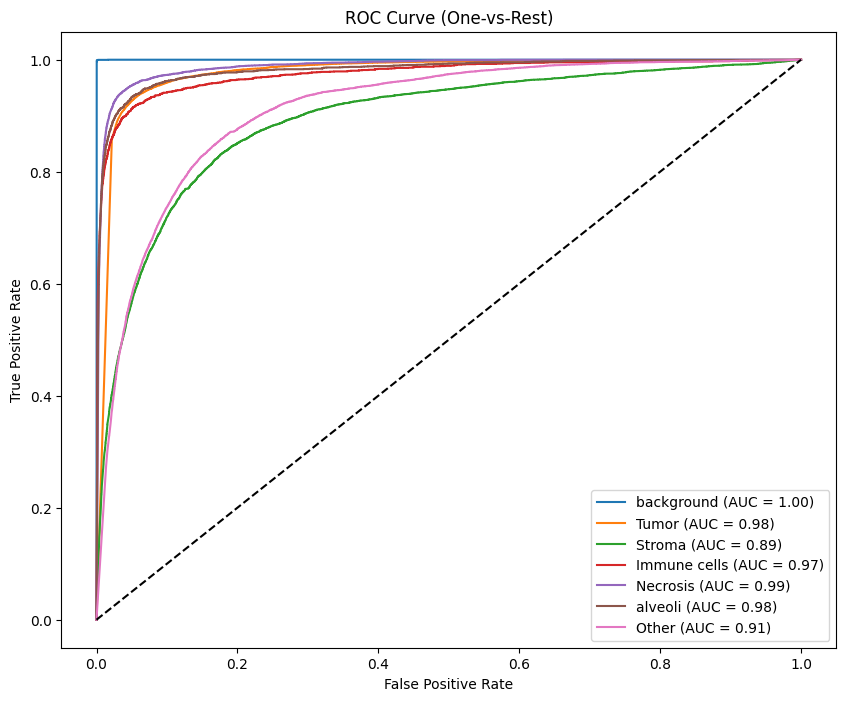

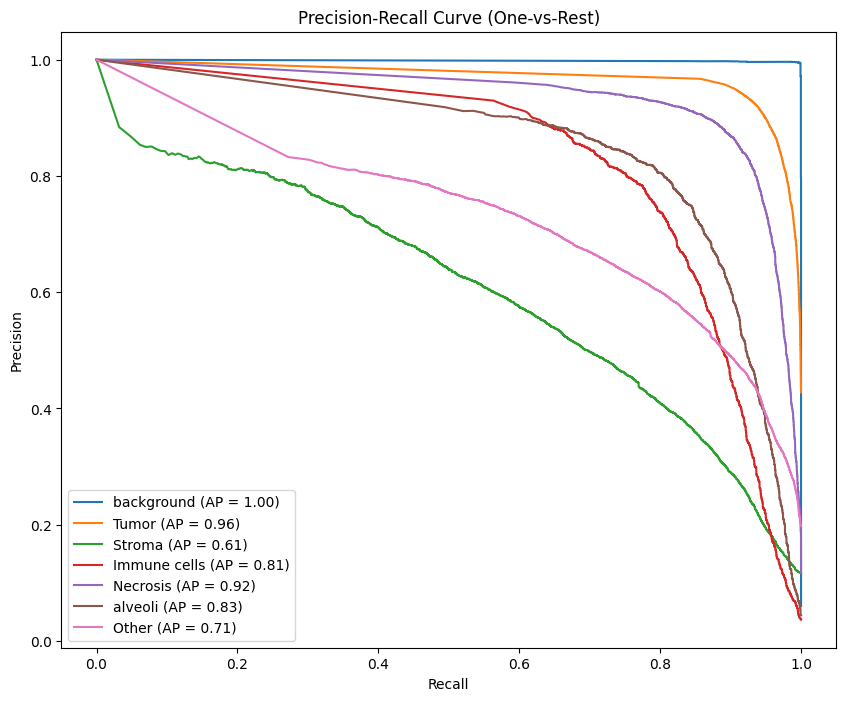

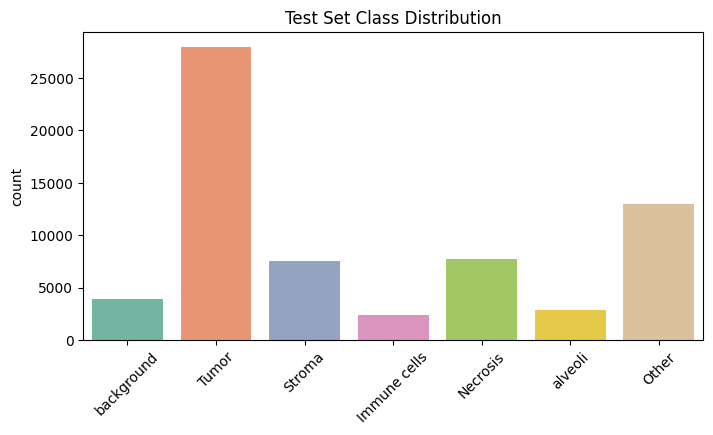

--- 논문용 분류 성능 요약 ---
background   | Precision: 0.9947 | Recall: 0.9987 | F1: 0.9967
Tumor        | Precision: 0.8936 | Recall: 0.9522 | F1: 0.9220
Stroma       | Precision: 0.6060 | Recall: 0.5537 | F1: 0.5787
Immune cells | Precision: 0.7399 | Recall: 0.7965 | F1: 0.7672
Necrosis     | Precision: 0.9035 | Recall: 0.8616 | F1: 0.8820
alveoli      | Precision: 0.8050 | Recall: 0.7966 | F1: 0.8008
Other        | Precision: 0.7021 | Recall: 0.6482 | F1: 0.6741
전체 정확도: 0.8255
Macro 평균 F1: 0.8031
Weighted 평균 F1: 0.8219


In [5]:
# 분류 결과 분석 및 시각화
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

# 모델 평가 함수
def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(torch.argmax(labels, dim=1).cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    return all_labels, all_preds, all_probs

# 클래스 이름 리스트
class_names = list(class_list.keys())

# 평가 실행
labels, preds, probs = evaluate_model(model, test_dataloader, device, class_names)

# 혼동 행렬
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 정밀도, 재현율, F1-score 등 상세 리포트
report = classification_report(labels, preds, target_names=class_names, digits=4, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# 전체 accuracy, macro/micro 평균 등
print('전체 정확도(Accuracy):', report['accuracy'])
print('Macro 평균 F1:', report['macro avg']['f1-score'])
print('Weighted 평균 F1:', report['weighted avg']['f1-score'])

# ROC Curve 및 AUC (One-vs-Rest, 다중 클래스)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)
labels_onehot = F.one_hot(torch.tensor(labels), num_classes=n_classes).numpy()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_onehot[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.show()

# Precision-Recall Curve 및 AP
plt.figure(figsize=(10,8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(labels_onehot[:, i], probs[:, i])
    ap = average_precision_score(labels_onehot[:, i], probs[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend()
plt.show()

# 클래스별 샘플 수 및 분포
plt.figure(figsize=(8,4))
sns.countplot(x=labels, palette='Set2')
plt.xticks(ticks=range(n_classes), labels=class_names, rotation=45)
plt.title('Test Set Class Distribution')
plt.show()

# 논문 작성용 요약
print('--- 논문용 분류 성능 요약 ---')
for cls in class_names:
    print(f"{cls:12s} | Precision: {report[cls]['precision']:.4f} | Recall: {report[cls]['recall']:.4f} | F1: {report[cls]['f1-score']:.4f}")
print(f"전체 정확도: {report['accuracy']:.4f}")
print(f"Macro 평균 F1: {report['macro avg']['f1-score']:.4f}")
print(f"Weighted 평균 F1: {report['weighted avg']['f1-score']:.4f}")